In [107]:
import os
import glob
import json
import h5py
import optparse
import sys
import traceback
import copy

import pandas as pd
import pylab as pl
import seaborn as sns
import numpy as np
import scipy as sp
import statsmodels as sm
import cPickle as pkl
import tifffile as tf

import numpy as np
from scipy.optimize import leastsq
import pylab as plt


from pipeline.python.utils import natural_keys, label_figure
from pipeline.python.retinotopy import target_visual_field as vf
from pipeline.python.retinotopy import visualize_rois as visroi
from pipeline.python.retinotopy import do_retinotopy_analysis as ra

In [3]:
%matplotlib notebook

In [4]:
def extract_options(options):
    
    parser = optparse.OptionParser()

    parser.add_option('-D', '--root', action='store', dest='rootdir', default='/n/coxfs01/2p-data', help='data root dir (root project dir containing all animalids) [default: /nas/volume1/2photon/data, /n/coxfs01/2pdata if --slurm]')
    parser.add_option('-i', '--animalid', action='store', dest='animalid', default='', help='Animal ID')

    # Set specific session/run for current animal:
    parser.add_option('-S', '--session', action='store', dest='session', default='', \
                      help='session dir (format: YYYMMDD_ANIMALID')
    parser.add_option('-A', '--acq', action='store', dest='acquisition', default='FOV1', \
                      help="acquisition folder (ex: 'FOV1_zoom3x') [default: FOV1]")
    parser.add_option('-R', '--run', action='store', dest='run', default='retino_run1', \
                      help="name of run dir containing tiffs to be processed (ex: gratings_phasemod_run1)")
    parser.add_option('-t', '--retinoid', action='store', dest='retinoid', default='analysis001', \
                      help="name of retino ID (roi analysis) [default: analysis001]")
    
    parser.add_option('--angular', action='store_false', dest='use_linear', default=True, \
                      help="Plot az/el coordinates in angular spce [default: plots linear coords]")
#     parser.add_option('-e', '--thr-el', action='store', dest='fit_thresh_el', default=0.2, \
#                       help="fit threshold for elevation [default: 0.2]")
#     parser.add_option('-a', '--thr-az', action='store', dest='fit_thresh_az', default=0.2, \
#                       help="fit threshold for azimuth [default: 0.2]")
    
    (options, args) = parser.parse_args(options)

    return options

# Select data source and params

In [5]:
options = ['-i', 'JC047', '-S', '20190215', '-A', 'FOV1']
#options = ['-i', 'JC070', '-S', '20190314', '-A', 'FOV1']
#options = ['-i', 'JC059', '-S', '20190227', '-A', 'FOV4']

#options = ['-i', 'JC059', '-S', '20190228', '-A', 'FOV1']

opts = extract_options(options)

rootdir = opts.rootdir
animalid = opts.animalid
session = opts.session
fov = opts.acquisition
run = opts.run
retinoid = opts.retinoid
use_linear = opts.use_linear
#fit_thresh_az = float(opts.fit_thresh_az)
#fit_thresh_el = float(opts.fit_thresh_el) #0.2

# Select analyzed dataset

In [6]:
#%%
use_pixels = False

run_dir = glob.glob(os.path.join(rootdir, animalid, session, '%s*' % fov, run))[0]
fov = os.path.split(os.path.split(run_dir)[0])[-1]
print("FOV: %s, run: %s" % (fov, run))
retinoids_fpath = glob.glob(os.path.join(run_dir, 'retino_analysis', 'analysisids_*.json'))[0]
with open(retinoids_fpath, 'r') as f:
    rids = json.load(f)
if use_pixels:
    roi_analyses = [r for r, rinfo in rids.items() if rinfo['PARAMS']['roi_type'] == 'pixels']
else:
    roi_analyses = [r for r, rinfo in rids.items() if rinfo['PARAMS']['roi_type'] != 'pixels']
if retinoid not in roi_analyses:
    retinoid = sorted(roi_analyses, key=natural_keys)[-1] # use most recent roi analysis
    print("Fixed retino id to most recent: %s" % retinoid)

data_identifier = '|'.join([animalid, session, fov, run, retinoid])

print("*** Dataset: %s ***" % data_identifier)

#%%
# Get processed retino data:
processed_dir = glob.glob(os.path.join(run_dir, 'retino_analysis', '%s*' % retinoid))[0]
processed_fpaths = glob.glob(os.path.join(processed_dir, 'files', '*.h5'))
print("Found %i processed retino runs." % len(processed_fpaths))

# Get condition info for trials:
conditions_fpath = glob.glob(os.path.join(run_dir, 'paradigm', 'files', '*.json'))[0]


FOV: FOV1_zoom4p0x, run: retino_run1
Fixed retino id to most recent: analysis002
*** Dataset: JC047|20190215|FOV1_zoom4p0x|retino_run1|analysis002 ***
Found 12 processed retino runs.


# Set output dir

In [23]:
output_dir = os.path.join(processed_dir, 'visualization', 'absolute_maps')
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
print("Saving fit results to: %s" % output_dir)

Saving fit results to: /n/coxfs01/2p-data/JC047/20190215/FOV1_zoom4p0x/retino_run1/retino_analysis/analysis002_d96d67/visualization/absolute_maps


# Get screen info

In [8]:
# Get screen info:
screen = visroi.get_screen_info(animalid, session, rootdir=rootdir)


# Convert phase to linear coords:
screen_left = -1*screen['azimuth']/2.
screen_right = screen['azimuth']/2. #screen['azimuth']/2.
screen_lower = -1*screen['elevation']/2.
screen_upper = screen['elevation']/2. #screen['elevation']/2.


Found epi sessions: ['20190215']
Most recent: 20190215
('-- getting screen info from:', ['/n/coxfs01/2p-data/JC047/epi_maps/20190215/screen_boundaries_20190215_epi_run8_fwhm_7_thresh_0.02.json', '/n/coxfs01/2p-data/JC047/epi_maps/20190215/screen_boundaries_20190215_epi_run3_fwhm_7_thresh_0.1.json'])
*********************************
{   'azimuth': 81.2812,
    'bb_left': 22.542832812500002,
    'bb_lower': 3.337395833333332,
    'bb_right': 31.671092578125005,
    'bb_upper': 14.899088541666668,
    'elevation': 45.77,
    'resolution': [1024, 768]}
*********************************


# Load data

### 1.  Load zprojection image for visualization

Found 12 mean-projection imgs.


<IPython.core.display.Javascript object>


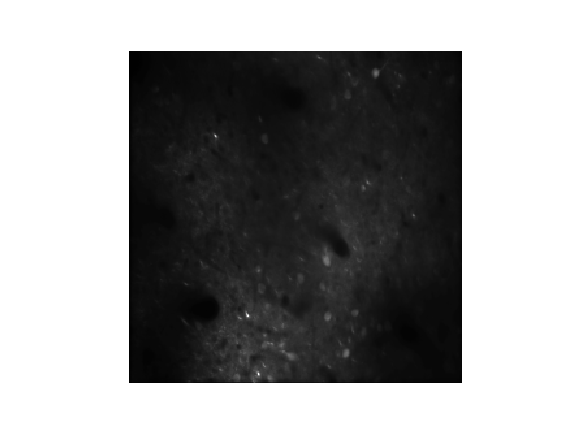

(-0.5, 255.5, 255.5, -0.5)

In [10]:
mean_projection_fpaths = glob.glob(os.path.join('%s_mean_deinterleaved' % rids[retinoid]['SRC'],
                                                'visible', '*.tif'))
print "Found %i mean-projection imgs." % len(mean_projection_fpaths)
imgs = []
for fp in mean_projection_fpaths:
    im = tf.imread(fp)
    if rids[retinoid]['PARAMS']['downsample_factor'] is not None:
        ds = int(rids[retinoid]['PARAMS']['downsample_factor'])
        im = ra.block_mean(im, ds)
    tmp_im = np.uint8(np.true_divide(im, np.max(im))*255)
    imgs.append(tmp_im)
    
fov_img = np.array(imgs).mean(axis=0)

pl.figure()
pl.imshow(fov_img, 'gray')
pl.axis('off')

### 2.  Load averaged traces (timecourses)

In [11]:
# This file gets created with visualization/get_session_summary() when estimate_RF_size.py is used

avg_traces_fpath = glob.glob(os.path.join(processed_dir, 'traces', '*.pkl'))[0]
print("Loading pre-averaged traces from: %s" % avg_traces_fpath)

with open(avg_traces_fpath, 'rb') as f:
    traces = pkl.load(f)
print("averaged_traces.pkl contains:", traces.keys())

# trials_by_cond = traces['conditions']
# print("Conditions (by rep):", trials_by_cond)

print "Cond dict:", traces['traces']['right']

Loading pre-averaged traces from: /n/coxfs01/2p-data/JC047/20190215/FOV1_zoom4p0x/retino_run1/retino_analysis/analysis002_d96d67/traces/averaged_roi_traces.pkl
('averaged_traces.pkl contains:', ['source_tifs', 'traces', 'RETINOID', 'masks', 'mwinfo', 'conditions'])
Cond dict: {'info': {'stimulus': u'right', 'stimfreq': 0.13, 'frame_rate': 44.6329, 'n_reps': 3}, 'traces': array([[  3.79618043e+00,   3.65672880e+00,   3.75006778e+00, ...,
          2.42589203e+00,   5.22900404e-01,  -1.12550637e+00],
       [ -5.46177363e+00,  -4.25502803e+00,  -5.06569435e+00, ...,
         -3.04327511e-01,  -3.43201620e+00,  -3.24832549e+00],
       [  1.71320712e+00,   2.19038241e+00,   2.09775858e-03, ...,
         -3.51555743e+00,  -2.72986144e+00,  -4.17969142e-01],
       ..., 
       [  9.46756677e+00,   4.26263107e+00,   2.26369001e+00, ...,
         -1.74497523e+00,  -1.34530110e+00,  -1.40808100e+00],
       [ -8.16790348e+00,  -1.22812778e+01,  -1.83349096e+01, ...,
          1.72754919e+01, 

### 3.  Load and format FFT analysis

In [89]:
# Comine all trial data into data frames:
fit, magratio, phase, trials_by_cond = vf.trials_to_dataframes(processed_fpaths, conditions_fpath)
#print fit.head()
print trials_by_cond
conditions = trials_by_cond.keys()

# Correct phase to wrap around:
corrected_phase = vf.correct_phase_wrap(phase)


1: retino_data_FOV1_retino_Slice01_Channel01_File001.h5
2: retino_data_FOV1_retino_Slice01_Channel01_File002.h5
3: retino_data_FOV1_retino_Slice01_Channel01_File003.h5
4: retino_data_FOV1_retino_Slice01_Channel01_File004.h5
5: retino_data_FOV1_retino_Slice01_Channel01_File005.h5
6: retino_data_FOV1_retino_Slice01_Channel01_File006.h5
7: retino_data_FOV1_retino_Slice01_Channel01_File007.h5
8: retino_data_FOV1_retino_Slice01_Channel01_File008.h5
9: retino_data_FOV1_retino_Slice01_Channel01_File009.h5
10: retino_data_FOV1_retino_Slice01_Channel01_File010.h5
11: retino_data_FOV1_retino_Slice01_Channel01_File011.h5
12: retino_data_FOV1_retino_Slice01_Channel01_File012.h5
{u'top': [11, 5, 6], u'right': [1, 4, 8], u'left': [10, 2, 7], u'bottom': [12, 3, 9]}


### 4.  Get stimulus parameters

In [15]:
# Get cycle starts:
cond = 'right'
stimfreq = traces['traces'][cond]['info']['stimfreq']
stimperiod = 1./stimfreq # sec per cycle
fr = traces['traces'][cond]['info']['frame_rate']
nframes = traces['traces'][cond]['traces'].shape[-1]

ncycles = int(round((nframes/fr) / stimperiod))
print stimperiod

nframes_per_cycle = int(np.floor(stimperiod * fr))
cycle_starts = np.round(np.arange(0, stimperiod*fr*ncycles, nframes_per_cycle)).astype('int')
print("Cycle starts (%i cycles):" % (ncycles), cycle_starts)

7.69230769231
('Cycle starts (12 cycles):', array([   0,  343,  686, 1029, 1372, 1715, 2058, 2401, 2744, 3087, 3430,
       3773, 4116]))


# Visualize "strong" cells

In [72]:
use_magratio = True

fit_thr = 0.2
mag_thr = 0.02

if use_magratio:
    roi_metric = 'magratio'
    means_by_metric = magratio.mean(axis=1)
    metric_thr = mag_thr
else:
    roi_metric = 'sinufit'
    means_by_metric = fit.mean(axis=1)
    metric_thr = fit_thr
    
strong_cells = means_by_metric[means_by_metric >= metric_thr].index.tolist()

print('ROIs with best %s (n=%i, thr=%.2f):' % (roi_metric, len(strong_cells), metric_thr), strong_cells)
print "Means by metric:"
print means_by_metric.head(), means_by_metric.shape

 ('ROIs with best magratio (n=45, thr=0.02):', [3, 5, 12, 13, 14, 17, 18, 19, 23, 24, 26, 27, 28, 29, 31, 32, 33, 34, 36, 37, 38, 39, 42, 46, 47, 49, 53, 55, 60, 62, 63, 64, 65, 72, 77, 80, 83, 91, 96, 97, 98, 100, 102, 106, 107])
Means by metric:
0    0.006021
1    0.007930
2    0.004981
3    0.057848
4    0.011858
dtype: float64 (108,)


### 1.  Plot timecourses by condition for each cell

<IPython.core.display.Javascript object>


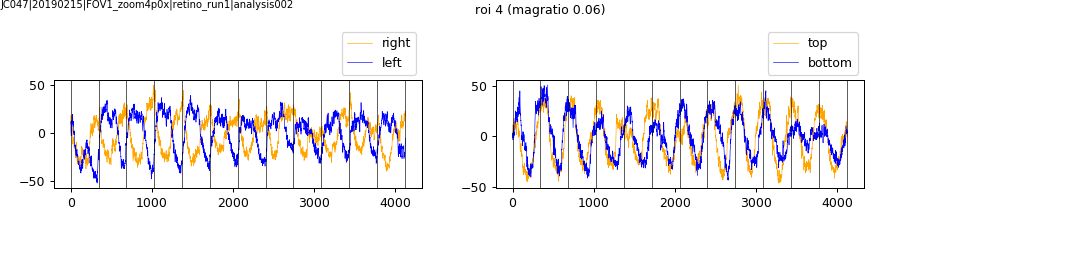

In [80]:
rid = 3
fig, axes = pl.subplots(1, 2, figsize=(12,3))

ax = axes[0]
ax.plot(traces['traces']['right']['traces'][rid, :], 'orange', lw=0.5, label='right')
ax.plot(traces['traces']['left']['traces'][rid, :], 'b', lw=0.5, label='left')
for cyc in cycle_starts:
    ax.axvline(x=cyc, color='k', lw=0.5)
ax.legend(loc='upper right', bbox_to_anchor=(1.0, 1.5))

ax = axes[1]
ax.plot(traces['traces']['top']['traces'][rid, :], 'orange', lw=0.5, label='top')
ax.plot(traces['traces']['bottom']['traces'][rid, :], 'b', lw=0.5, label='bottom')
for cyc in cycle_starts:
    ax.axvline(x=cyc, color='k', lw=0.5)
ax.legend(loc='upper right', bbox_to_anchor=(1.0, 1.5))

fig.suptitle('roi %i (%s %.2f)' % (int(rid+1), roi_metric, means_by_metric[rid]), fontsize=10)

fig.subplots_adjust(right=0.8, top=0.7, bottom=0.3, left=0.05, wspace=0.2)

label_figure(fig, data_identifier)


<IPython.core.display.Javascript object>


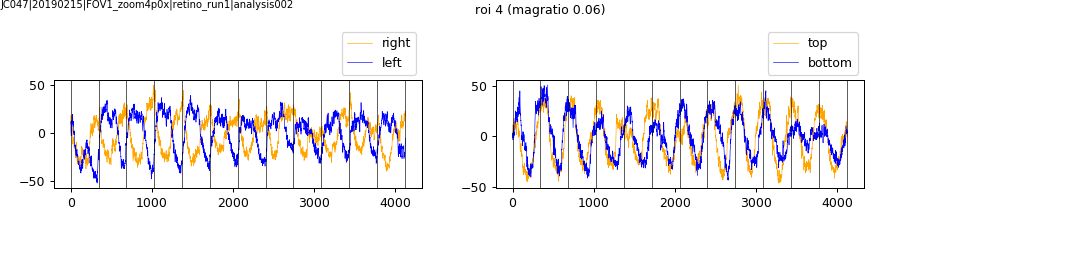

<IPython.core.display.Javascript object>


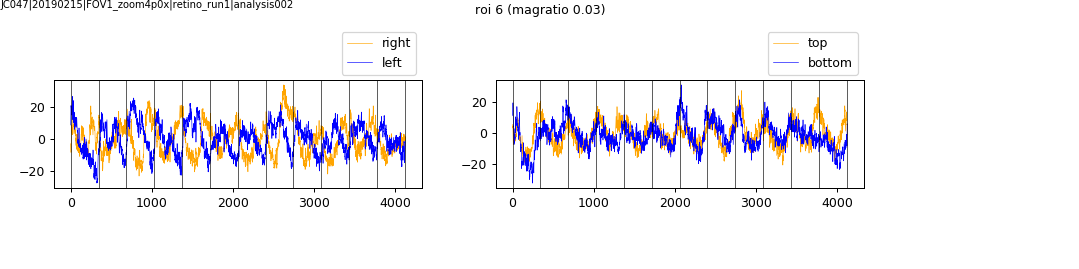

<IPython.core.display.Javascript object>


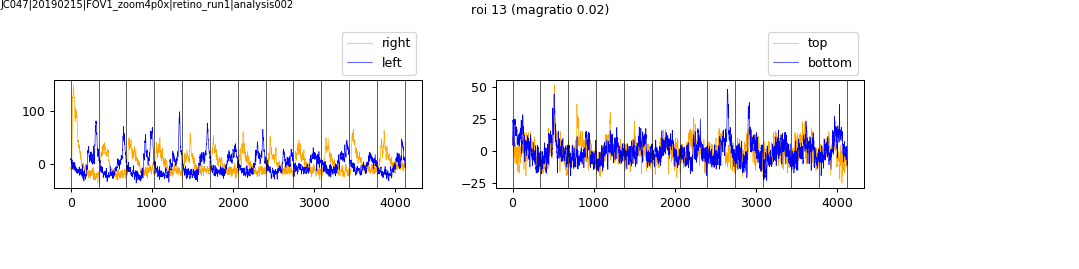

<IPython.core.display.Javascript object>


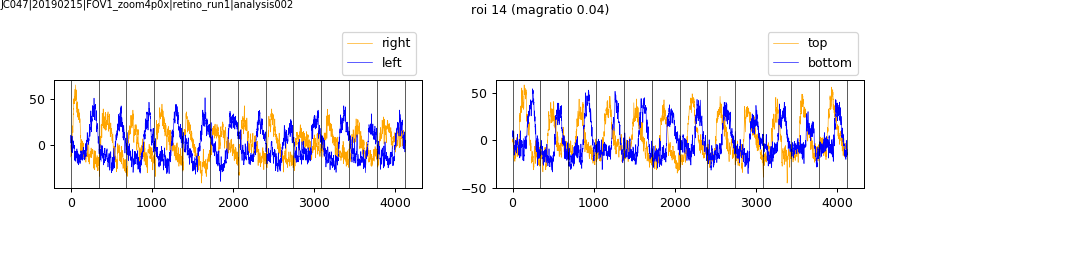

<IPython.core.display.Javascript object>


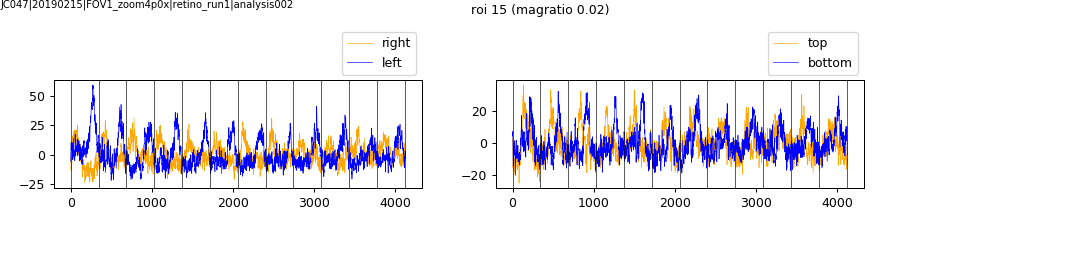

<IPython.core.display.Javascript object>


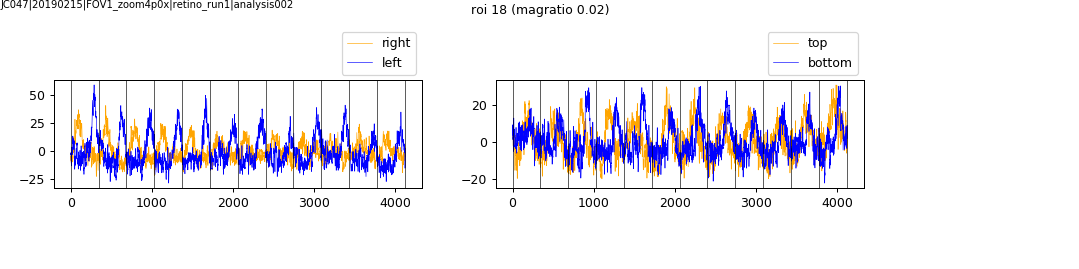

<IPython.core.display.Javascript object>


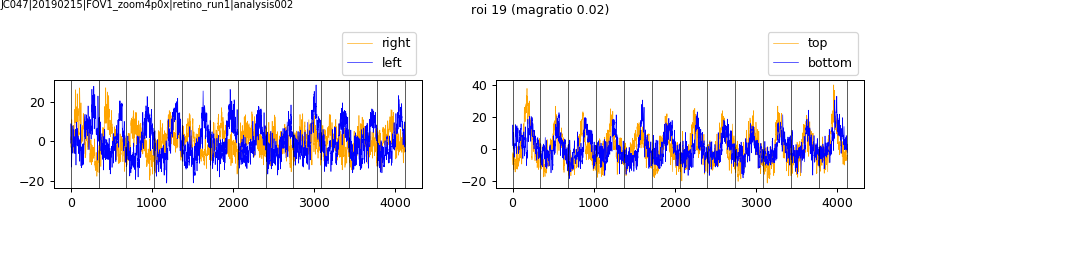

<IPython.core.display.Javascript object>


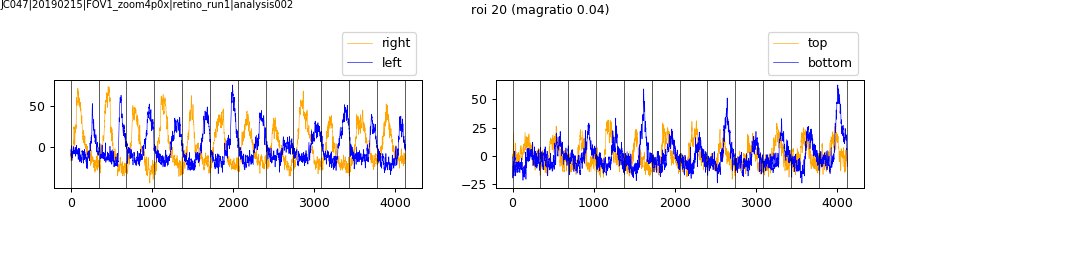

<IPython.core.display.Javascript object>


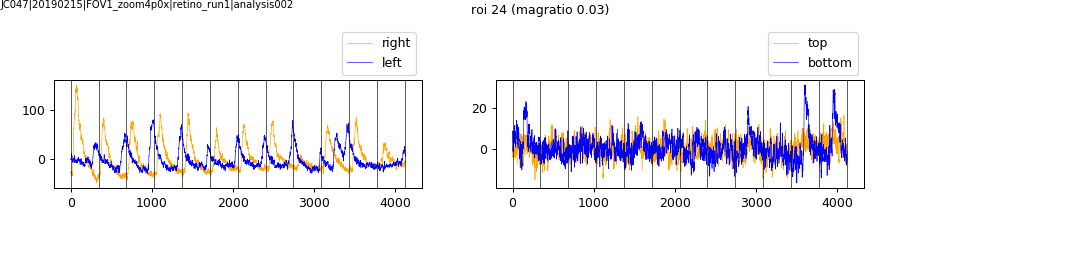

<IPython.core.display.Javascript object>


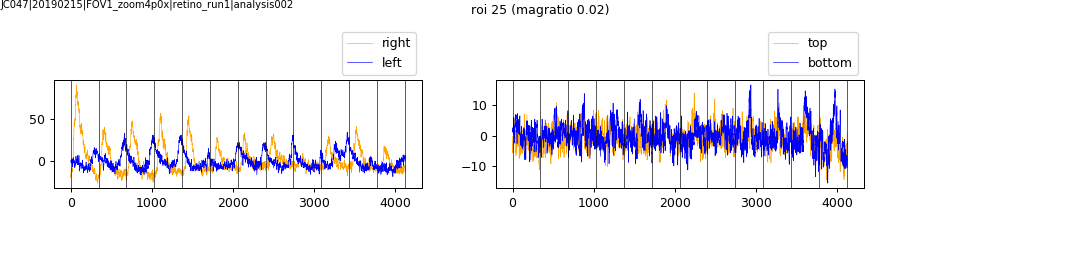

<IPython.core.display.Javascript object>


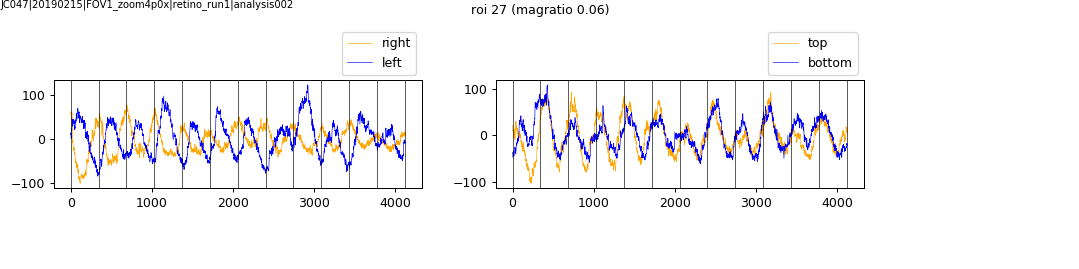

<IPython.core.display.Javascript object>


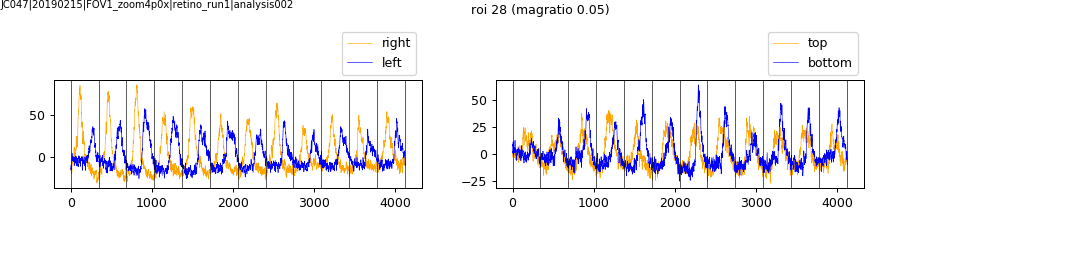

<IPython.core.display.Javascript object>


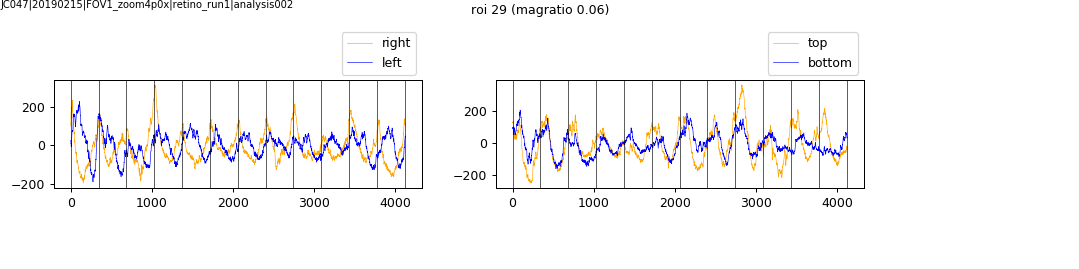

<IPython.core.display.Javascript object>


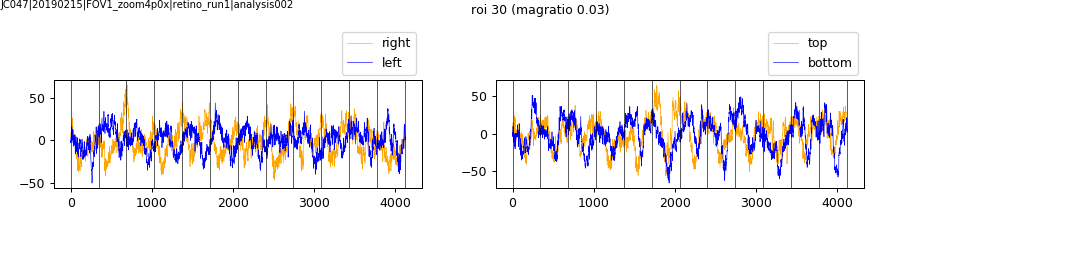

<IPython.core.display.Javascript object>


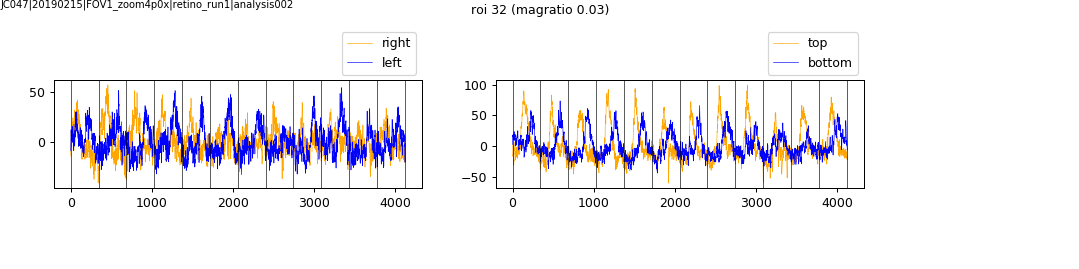

<IPython.core.display.Javascript object>


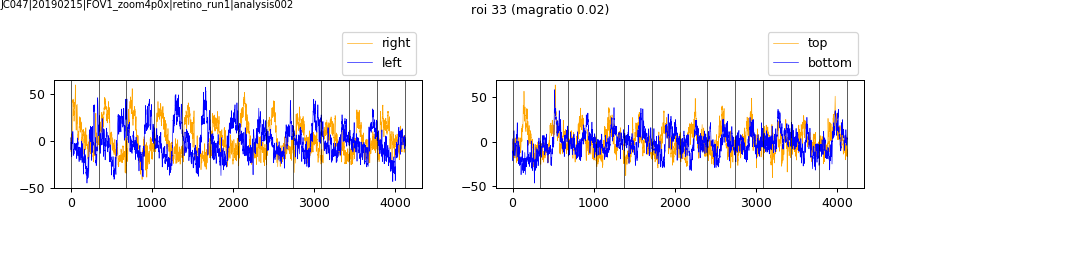

<IPython.core.display.Javascript object>


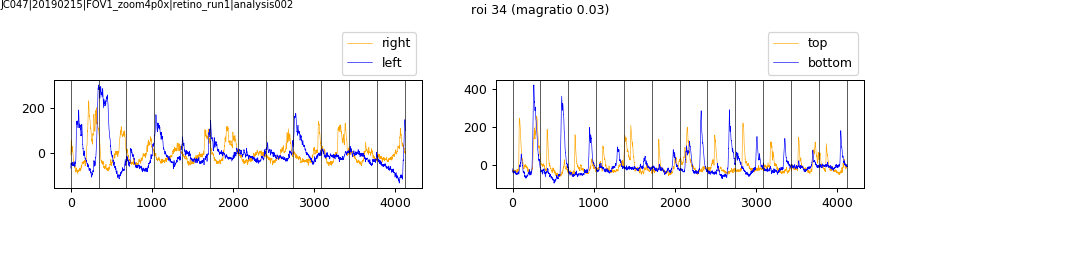

<IPython.core.display.Javascript object>


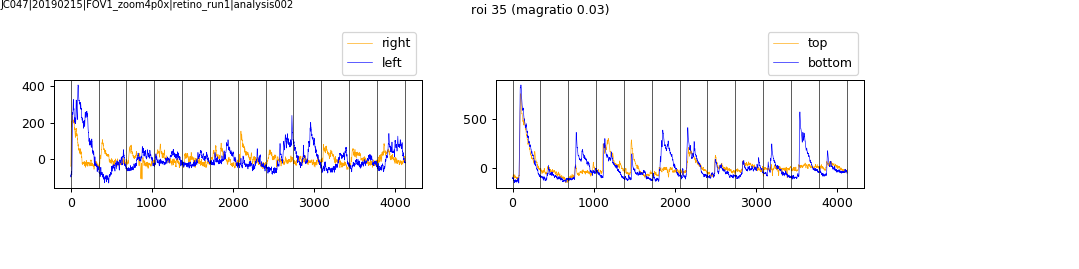

<IPython.core.display.Javascript object>


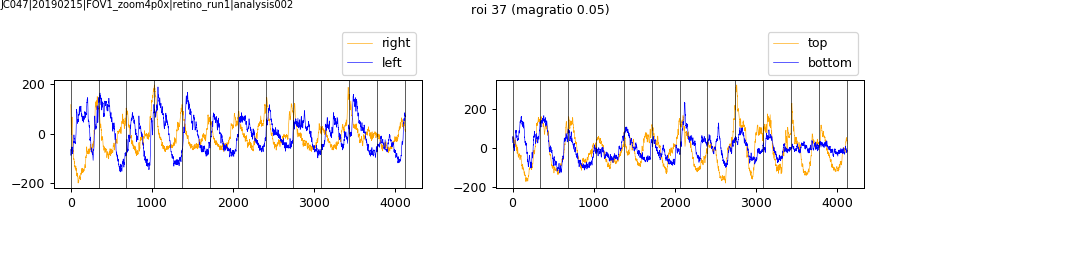

<IPython.core.display.Javascript object>


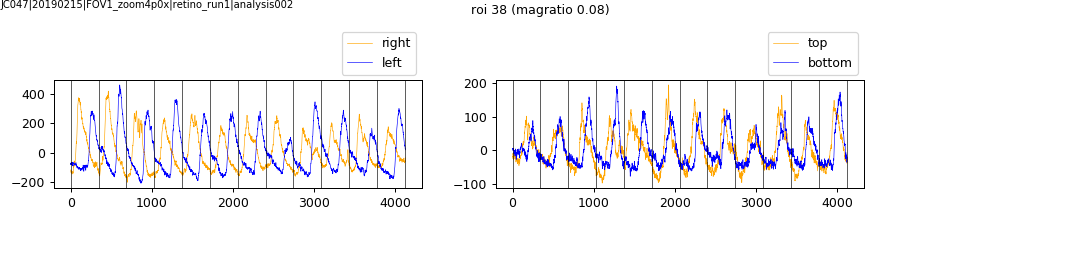

<IPython.core.display.Javascript object>


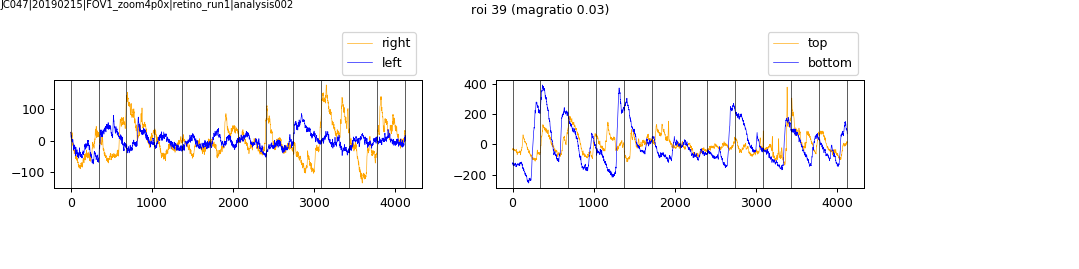

<IPython.core.display.Javascript object>


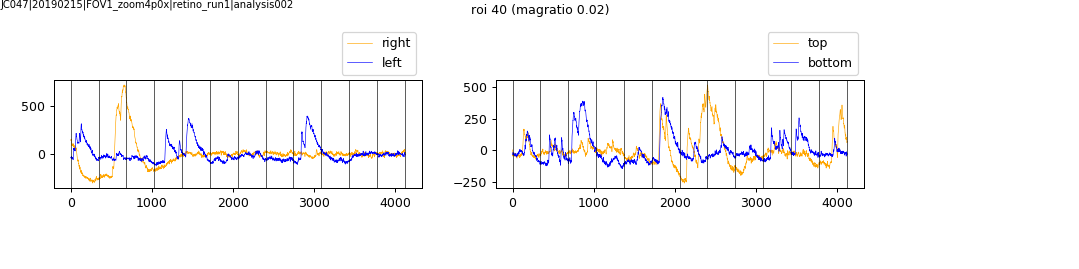

<IPython.core.display.Javascript object>


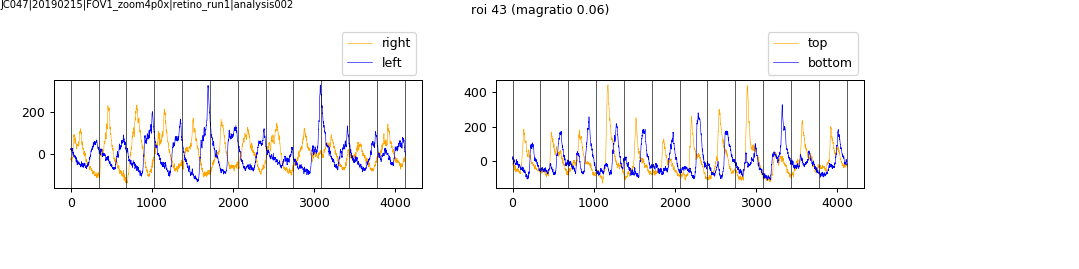

<IPython.core.display.Javascript object>


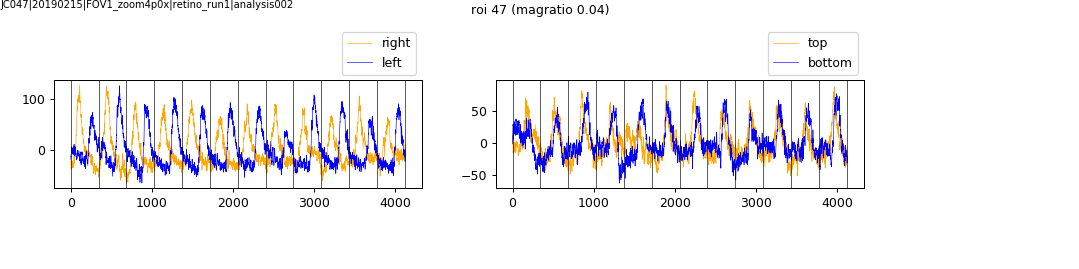

<IPython.core.display.Javascript object>


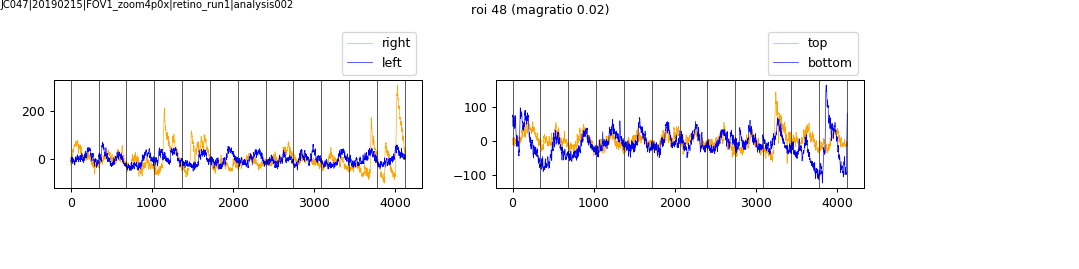

<IPython.core.display.Javascript object>


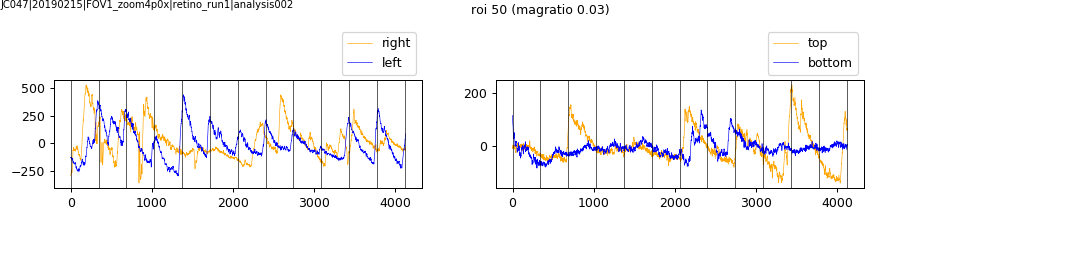

<IPython.core.display.Javascript object>


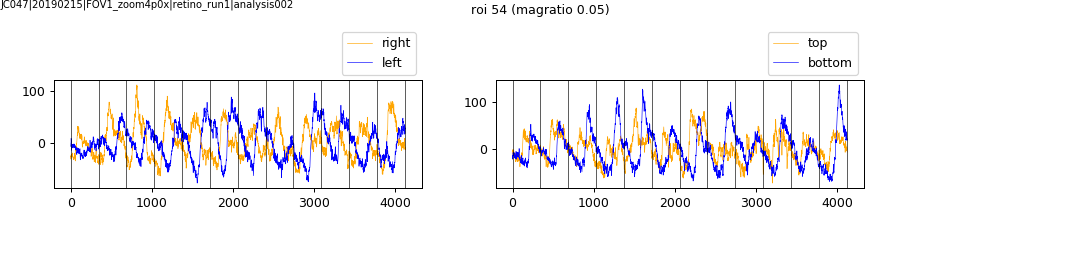

<IPython.core.display.Javascript object>


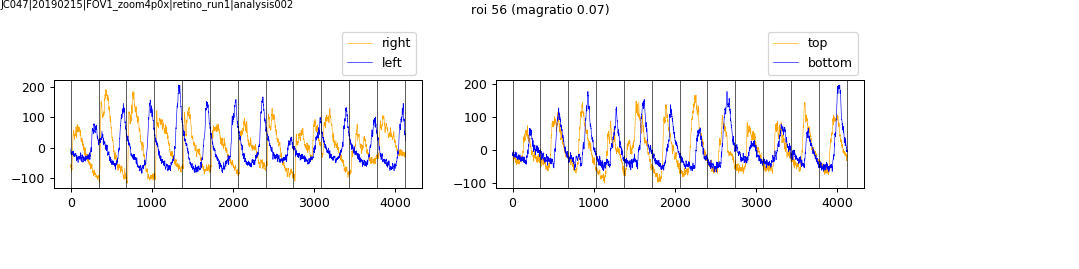

<IPython.core.display.Javascript object>


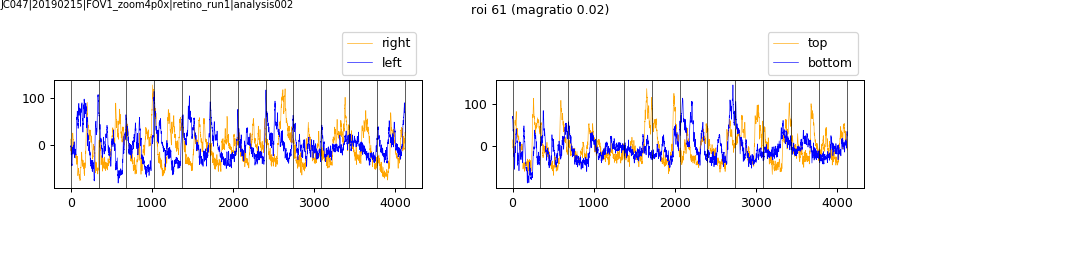

<IPython.core.display.Javascript object>


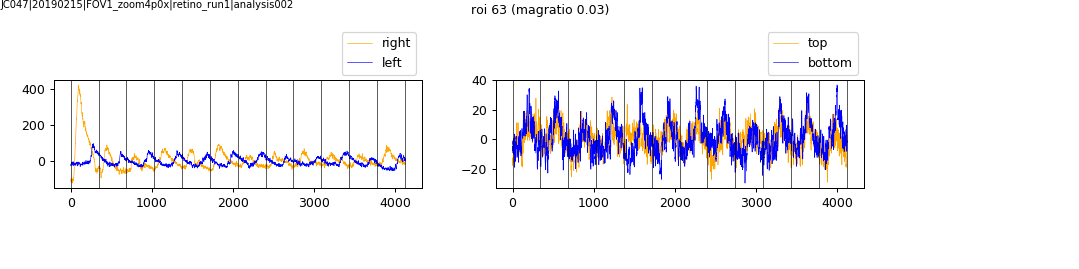

<IPython.core.display.Javascript object>


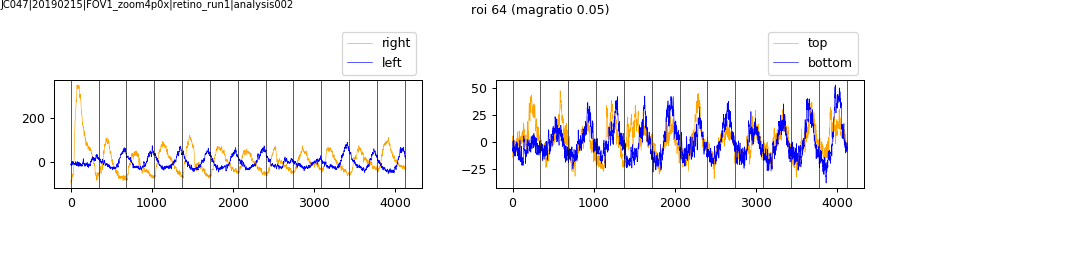

<IPython.core.display.Javascript object>


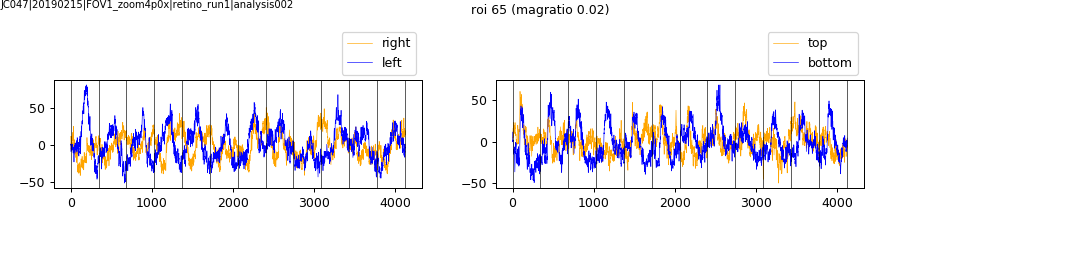

<IPython.core.display.Javascript object>


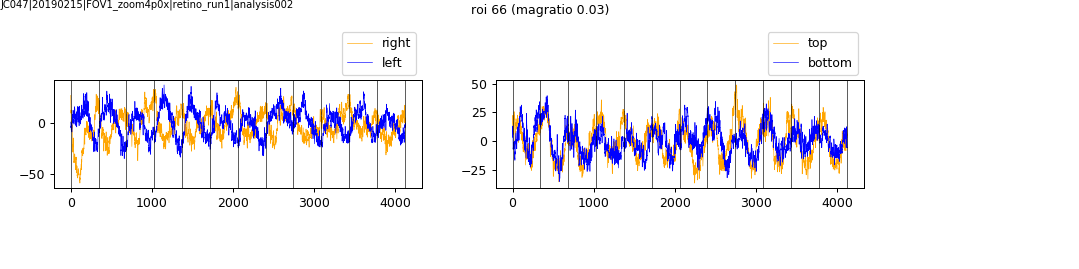

<IPython.core.display.Javascript object>


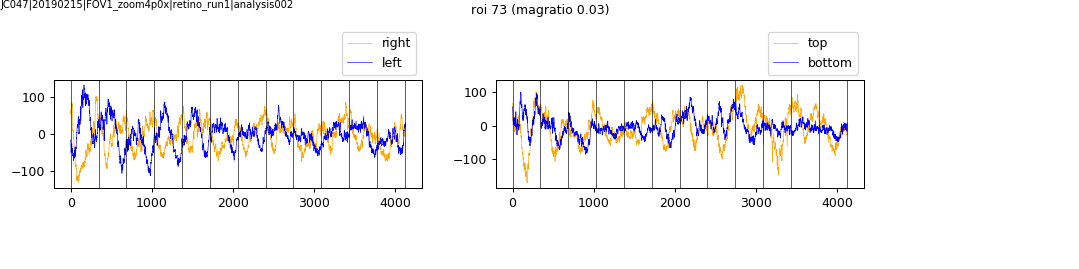

<IPython.core.display.Javascript object>


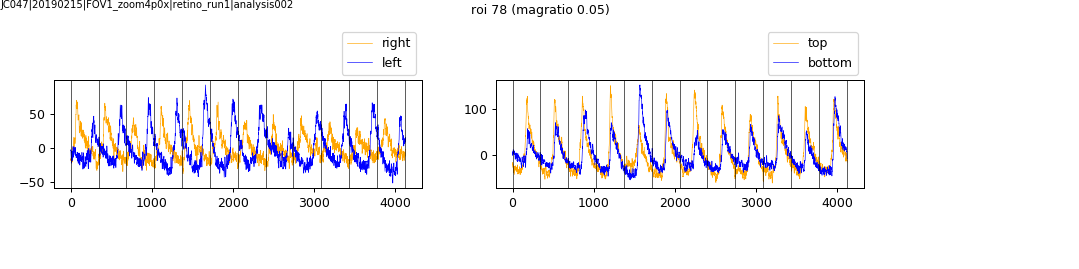

<IPython.core.display.Javascript object>


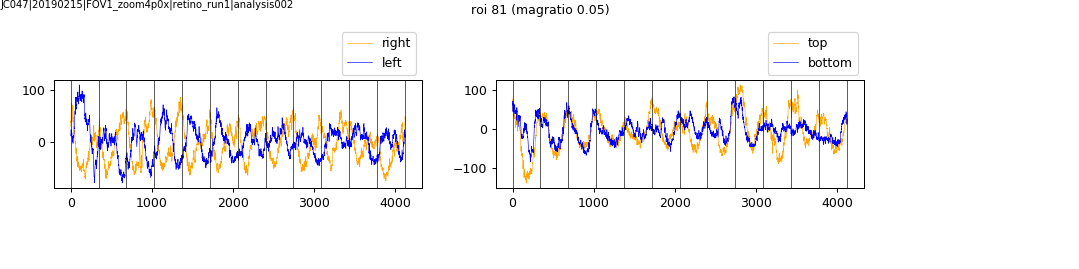

<IPython.core.display.Javascript object>


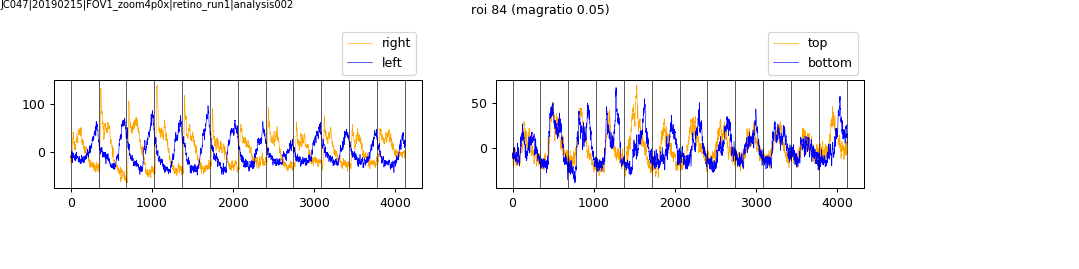

<IPython.core.display.Javascript object>


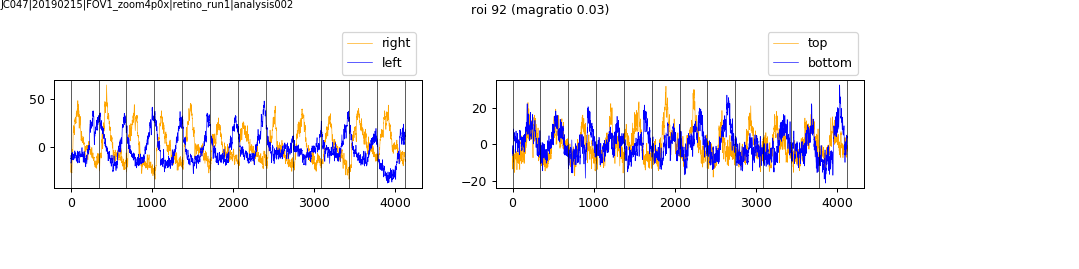

<IPython.core.display.Javascript object>


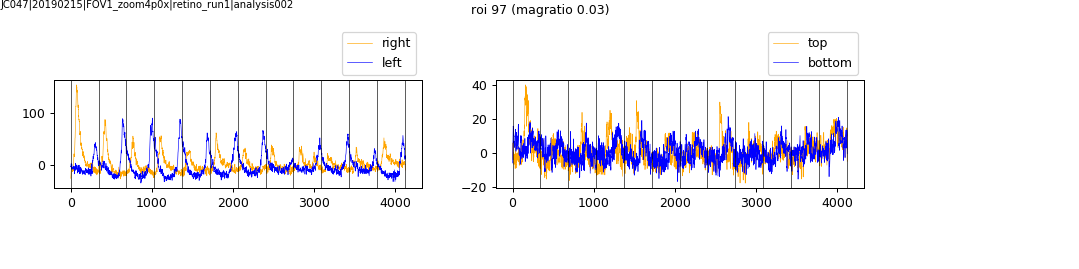

<IPython.core.display.Javascript object>


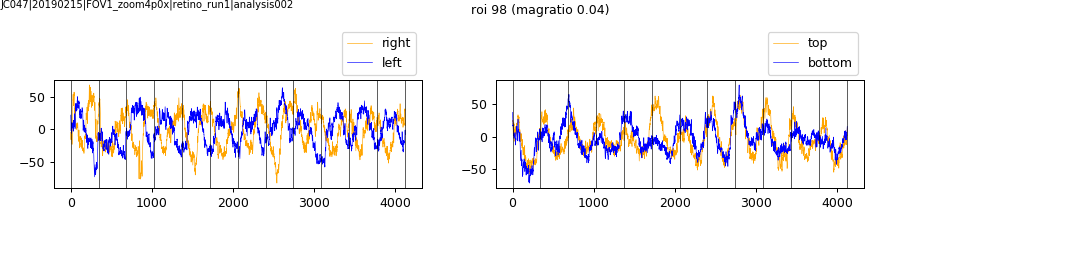

<IPython.core.display.Javascript object>


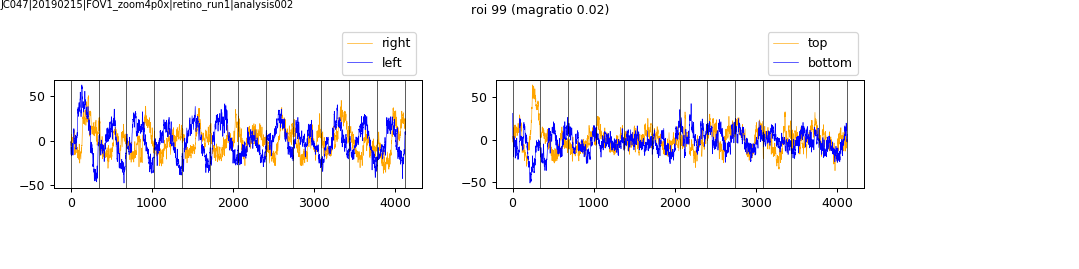

<IPython.core.display.Javascript object>


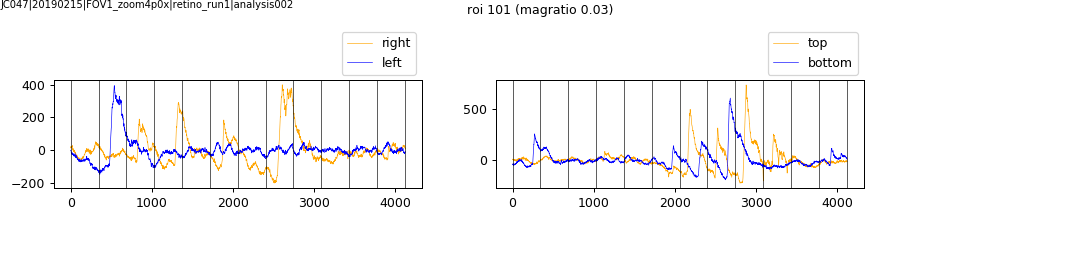

<IPython.core.display.Javascript object>


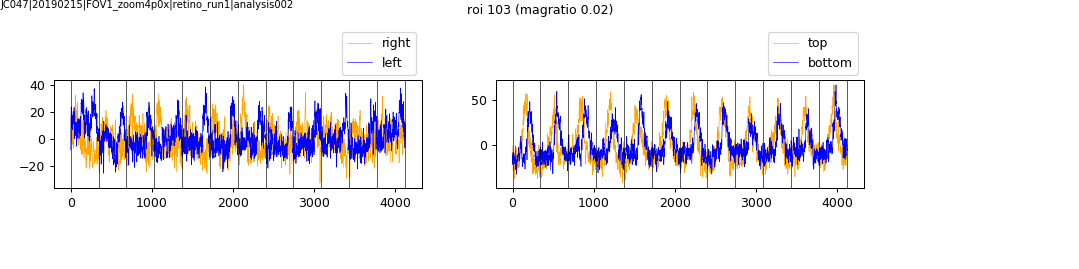

<IPython.core.display.Javascript object>


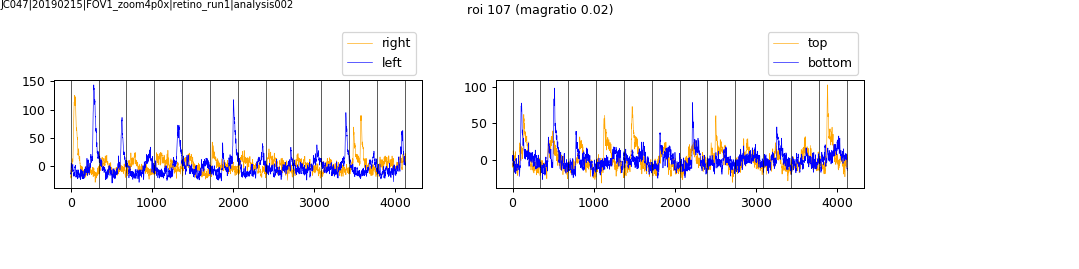

<IPython.core.display.Javascript object>


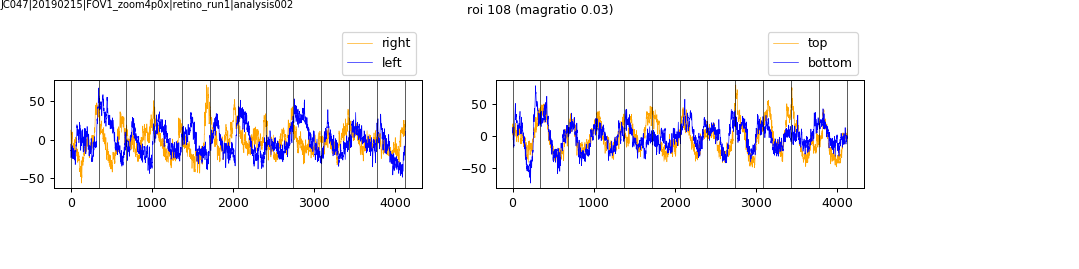

In [103]:

if not os.path.exists(os.path.join(output_dir, 'roi_traces')):
    os.makedirs(os.path.join(output_dir, 'roi_traces'))

for ri,rid in enumerate(strong_cells):
    fig, axes = pl.subplots(1, 2, figsize=(12,3))

    ax = axes[0]
    ax.plot(traces['traces']['right']['traces'][rid, :], 'orange', lw=0.5, label='right')
    ax.plot(traces['traces']['left']['traces'][rid, :], 'b', lw=0.5, label='left')
    for cyc in cycle_starts:
        ax.axvline(x=cyc, color='k', lw=0.5)
    ax.legend(loc='upper right', bbox_to_anchor=(1.0, 1.5))

    ax = axes[1]
    ax.plot(traces['traces']['top']['traces'][rid, :], 'orange', lw=0.5, label='top')
    ax.plot(traces['traces']['bottom']['traces'][rid, :], 'b', lw=0.5, label='bottom')
    for cyc in cycle_starts:
        ax.axvline(x=cyc, color='k', lw=0.5)
    ax.legend(loc='upper right', bbox_to_anchor=(1.0, 1.5))

    fig.suptitle('roi %i (%s %.2f)' % (int(rid+1), roi_metric, means_by_metric[rid]), fontsize=10)
    fig.subplots_adjust(right=0.8, top=0.7, bottom=0.3, left=0.05, wspace=0.2)

    label_figure(fig, data_identifier)
    pl.savefig(os.path.join(output_dir, 'roi_traces', 'azim_elev_roi%05d.png' % int(rid+1)))

# Get absolute maps

#### Get average phase of each condition (for all cells)

In [193]:
# First look at left v. right:

is_azimuth = True
threshold_by_metric = True

if is_azimuth:
    c1 = 'left' #'right'
    c2 = 'right' #'left'
else:
    c1 = 'bottom' #'right'
    c2 = 'top' #'left'

In [194]:
# Use uncorrected/wrapped phase values:

lowval = -np.pi
highval = np.pi

mean_phases = pd.concat((pd.DataFrame(sp.stats.circmean(phase[trials_by_cond[cond]], axis=1, low=lowval, high=highval),
                                    columns=[cond], index=phase.index) for cond in conditions), axis=1)

mean_phases.head()                 

top     right      left    bottom
0 -0.586720  1.759148 -2.593130 -0.625134
1  0.072540  0.198160 -0.060520  2.735313
2 -1.710808 -0.797809  1.545796 -2.629949
3 -0.336081  0.854199 -2.299201 -0.777062
4 -0.372178  1.102320 -2.701137 -1.451129

#### Load masks for ROIs

In [195]:
masks = traces['masks']
nrois, d1, d2 = masks.shape

#### Apply phase values to masks

In [196]:
tmp_cmask1 = np.ones((d1, d2))*100
tmp_cmask2 = np.ones((d1, d2)) *100

if threshold_by_metric:
    roi_list = copy.copy(strong_cells)
else:
    roi_list = np.arange(0, nrois)
    
for ri in roi_list: #np.arange(0, nrois):
    maskpix = np.where(np.squeeze(masks[ri,:,:])) 
        
    tmp_cmask1[maskpix] = mean_phases[c1][ri] 
    tmp_cmask2[maskpix] = mean_phases[c2][ri]

    tmp_cmask1 = np.ma.array(tmp_cmask1) # create masking array
    cmask1 = np.ma.masked_where(tmp_cmask1 == 100 , tmp_cmask1) # mask non-roi pixels

    tmp_cmask2 = np.ma.array(tmp_cmask2) # create masking array
    cmask2 = np.ma.masked_where(tmp_cmask2 == 100 , tmp_cmask2) # mask non-roi pixels


# Plot absolute maps

<IPython.core.display.Javascript object>


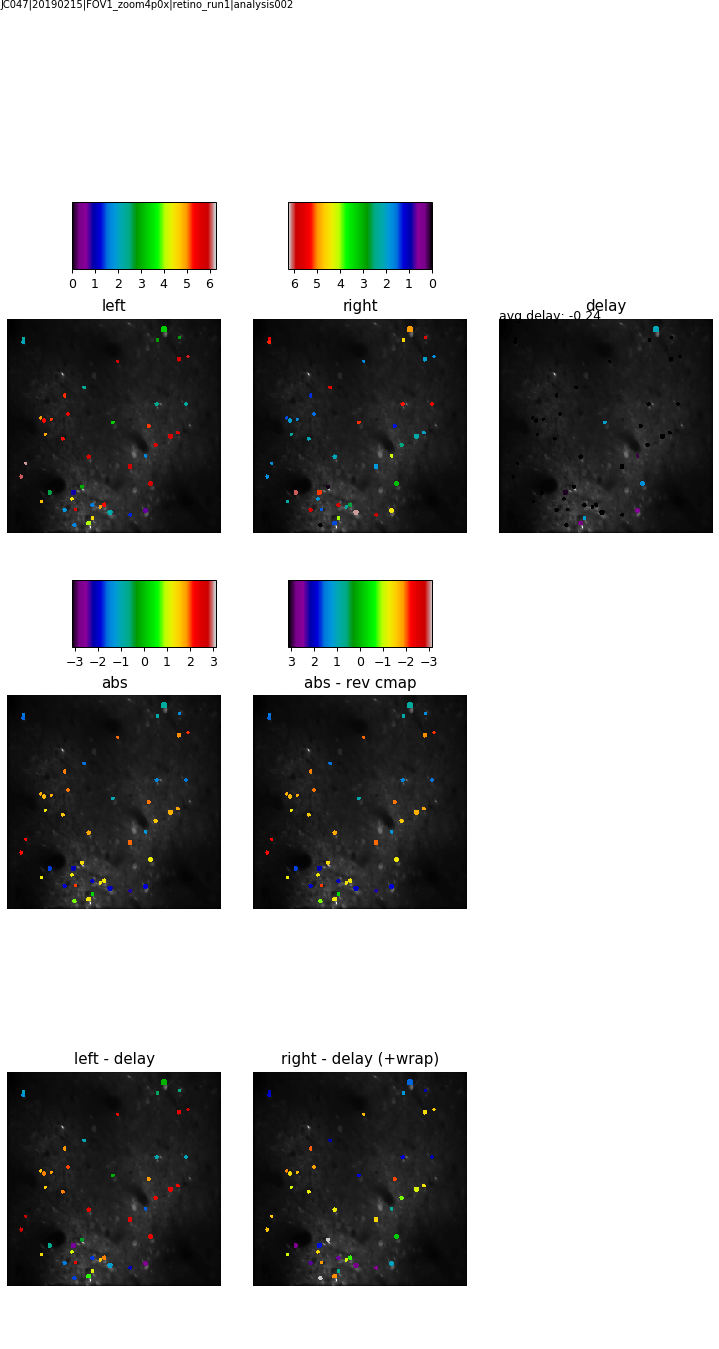

Mean delay (std): -0.24 (0.95)
left (mean): -0.09
right (mean): -0.38
left - right: max/min = 2.19, -2.27
right - left: max/min = 2.27, -2.19


In [197]:
fig, axes = pl.subplots(3,3, figsize=(8,15)) #pl.figure()
pl.subplots_adjust(hspace=0.2, wspace=0.15, top=0.8, left=0.01, right=0.99, bottom=0.01)

if c1 == 'right' or c1 == 'left':
    cbar_orientation='horizontal'
    cbar_axes1 = [0.1, 0.8, 0.2, 0.05]
    cbar_axes2 = [0.4, 0.8, 0.2, 0.05]
    cbar_axes1a = [0.1, 0.52, 0.2, 0.05]
    cbar_axes2a = [0.4, 0.52, 0.2, 0.05]
else:
    cbar_orientation='vertical'
    cbar_axes1 = [0.1, 0.9, 0.2, 0.05]
    cbar_axes2 = [0.4, 0.9, 0.2, 0.05]
    
# 1. Condition1 map
ax = axes[0, 0]
ax.imshow(fov_img, 'gray')
cmask1_wrap = vf.correct_phase_wrap(cmask1)
im = ax.imshow(cmask1_wrap.T, cmap='nipy_spectral', vmin=0, vmax=np.pi*2)
ax.set_title(c1); ax.axis('off')
cbaxes = fig.add_axes(cbar_axes1) 
cb = pl.colorbar(im, cax = cbaxes, orientation=cbar_orientation)  
# if is_azimuth:
#     cb.ax.invert_xaxis()
# else:
#     cb.ax.invert_yaxis() 


# 2.  Condition2 map
ax = axes[0, 1]
ax.imshow(fov_img, 'gray')
cmask2_wrap = vf.correct_phase_wrap(cmask2)
im = ax.imshow(cmask2_wrap.T, cmap='nipy_spectral', vmin=0, vmax=np.pi*2)
ax.set_title(c2); ax.axis('off')
cbaxes = fig.add_axes(cbar_axes2) 
cb = pl.colorbar(im, cax = cbaxes, orientation=cbar_orientation)  
if is_azimuth:
    cb.ax.invert_xaxis()
else:
    cb.ax.invert_yaxis() 
    
# --------------------------------------------------
# 3.  Delay map:
ax = axes[0, 2]
ax.imshow(fov_img, 'gray')
delay_map = (cmask1 + cmask2) / 2.
#delay_map = vf.correct_phase_wrap(delay_map) # do dis
delay = delay_map.mean()
im = ax.imshow(delay_map.T, cmap='nipy_spectral', vmin=0, vmax=np.pi*2)
ax.set_title('delay'); ax.axis('off')
ax.annotate('avg delay: %.2f' % delay_map.mean(), (0, 0.5))

# --------------------------------------------------

# 4. Abs map - cond1 
ax = axes[1, 0]
ax.imshow(fov_img, 'gray')
abs_map1 = (cmask1_wrap - cmask2_wrap) / 2.
#abs_map1 = vf.correct_phase_wrap(abs_map1) <-- dont do this if starting w/ corrected
im = ax.imshow(abs_map1.T, cmap='nipy_spectral', vmin=-np.pi, vmax=np.pi) #vmin=0, vmax=np.pi*2)
ax.set_title('abs'); ax.axis('off')
cbaxes = fig.add_axes(cbar_axes1a) 
cb = pl.colorbar(im, cax = cbaxes, orientation=cbar_orientation)  
# if is_azimuth:
#     cb.ax.invert_xaxis()
# else:
#     cb.ax.invert_yaxis() 
    
    
# 5. Abs map - cond2
ax = axes[1, 1]
ax.imshow(fov_img, 'gray')
abs_map2 = (cmask2_wrap - cmask1_wrap) / 2.
#abs_map2 = vf.correct_phase_wrap(abs_map2) <-- dont do this if starting w/ corrected
im = ax.imshow(abs_map2.T, cmap='nipy_spectral_r', vmin=-np.pi, vmax=np.pi) # <-- use reverse cmap to match abs condN
ax.set_title('abs - rev cmap'); ax.axis('off')
cbaxes = fig.add_axes(cbar_axes2a) 
cb = pl.colorbar(im, cax = cbaxes, orientation=cbar_orientation)  
if is_azimuth:
    cb.ax.invert_xaxis()
else:
    cb.ax.invert_yaxis() 
    
# --------------------------------------------------

# 6. Cond1, shifted by delay
ax = axes[2, 0]
ax.imshow(fov_img, 'gray')
#shift_map1 = cmask1_wrap - delay_map # <-- for shift, need phase calculated by non-wrapped, subtract from wrapped
shift_map1 = cmask1_wrap - np.abs(delay) #delay_map
#shift_map1 = vf.correct_phase_wrap(shift_map1)
im = ax.imshow(shift_map1.T, cmap='nipy_spectral', vmin=0, vmax=np.pi*2)
ax.set_title('%s - delay' % c1); ax.axis('off')

# 7. Cond2, shifted by delay
ax = axes[2, 1]
ax.imshow(fov_img, 'gray')
shift_map2 = cmask2_wrap - np.abs(delay) # delay_map
#shift_map2 = cmask2 - delay_map
#shift_map2 = vf.correct_phase_wrap(shift_map2)
im = ax.imshow(shift_map2.T, cmap='nipy_spectral_r', vmin=0, vmax=np.pi*2)
ax.set_title('%s - delay (+wrap)' % c2); ax.axis('off')


axes[1,2].axis('off')
axes[2,2].axis('off')

label_figure(fig, data_identifier)

if threshold_by_metric: 
    figname = 'absolute_phase_by_roi_%s_%s_%s_thr%.2f.png' % (c1, c2, roi_metric, metric_thr)
else:
    figname = 'absolute_phase_by_roi_%s_%s_all.png' % (c1, c2)
pl.savefig(os.path.join(output_dir, figname))


print "Mean delay (std): %.2f (%.2f)" % (delay_map.mean(), delay_map.std())
print "%s (mean): %.2f" % (c1, cmask1.mean()) # cmask2.max()
print "%s (mean): %.2f" % (c2, cmask2.mean()) # cmask2.max()


print "%s - %s: max/min = %.2f, %.2f" % (c1, c2, abs_map1.max(),abs_map1.min())
print "%s - %s: max/min = %.2f, %.2f" % (c2, c1, abs_map2.max(),abs_map2.min())

# Save absolute map to var:
if c1 == 'left' or c1 == 'right':
    absolute_az = abs_map1.copy()
else:
    absolute_el = abs_map1.copy()
    

# Plot a nicer plot with just absolute maps and legend

<IPython.core.display.Javascript object>


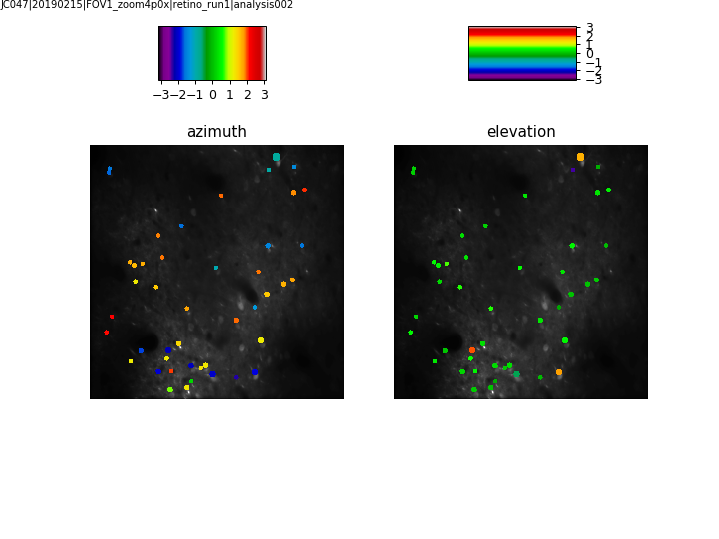

In [191]:
fig, axes = pl.subplots(1,2, figsize=(8,6))


cbar_axes1 = [0.22, 0.85, 0.15, 0.1]
cbar_axes2 = [0.65, 0.85, 0.15, 0.1]

    
ax = axes[0]
ax.imshow(fov_img, 'gray')
im = ax.imshow(absolute_az.T, cmap='nipy_spectral', vmin=-np.pi, vmax=np.pi) #vmin=0, vmax=np.pi*2)
ax.set_title('azimuth'); ax.axis('off')
cbaxes = fig.add_axes(cbar_axes1) 
cb = pl.colorbar(im, cax = cbaxes, orientation='horizontal')  

# 5. Abs map - cond2
ax = axes[1]
ax.imshow(fov_img, 'gray')
im = ax.imshow(absolute_el.T, cmap='nipy_spectral', vmin=-np.pi, vmax=np.pi) # <-- use reverse cmap to match abs condN
ax.set_title('elevation'); ax.axis('off')
cbaxes = fig.add_axes(cbar_axes2) 
cb = pl.colorbar(im, cax = cbaxes, orientation='vertical')  

pl.subplots_adjust(wspace=0.2, hspace=0.1)

label_figure(fig, data_identifier)

pl.savefig(os.path.join(output_dir, 'absolute_maps_%s_thr%.2f.png' % (roi_metric, metric_thr)))